# Soil Contamination Prediction Project

In this project we will use a dataset with recordings of different chemical compound levels in different soil to predict whether these soils are in danger of being contaminated.

Library and Dataset Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [27]:
df = pd.read_csv("soil.csv")

Dataset Reading and Basic Processing

In [4]:
df.head()

,ID,Sand %,Clay %,Silt %,pH,EC mS/cm,O.M. %,CACO3 %,N_NO3 ppm,P ppm,K ppm,Mg ppm,Fe ppm,Zn ppm,Mn ppm,Cu ppm,B ppm,contaminated
0,1,42.0,38.0,20.0,5.162,0.274,3.783414,0.00,14.462366,18.608840,147,1115,91.32,0.894,27.06,1.768,0.40,0
1,2,54.0,26.0,20.0,6.071,0.355,1.451688,0.00,14.587814,32.742137,180,1055,60.04,3.660,17.58,1.684,0.41,0
2,3,28.0,36.0,36.0,6.921,0.675,1.767599,0.40,14.910394,19.024525,183,1215,61.24,3.060,18.00,1.840,0.46,1
3,4,58.0,20.0,22.0,7.704,0.355,0.718322,6.80,4.211470,6.276846,116,327,19.54,1.640,5.04,0.844,0.50,1
4,5,33.2,41.2,25.6,7.609,0.392,0.996625,4.39,6.111111,6.553970,228,939,25.84,0.180,7.16,1.216,0.40,1


In [5]:
df2 = df.rename(columns={'Sand %':'Sand', 
'Clay %':'Clay',
'Silt %':'Silt',
"EC mS/cm":'EC',
'O.M. %':'O.M.',
'CACO3 %':'CACO3',
'N_NO3 ppm':'NO3',
'P ppm':'P',
'K ppm':'K',
'Mg ppm':'Mg',
'Fe ppm':'Fe',
'Zn ppm':'Zn',
'Mn ppm':'Mn',
'Cu ppm':'Cu',
'B ppm':'B',
'contaminated':'Contaminated'})
df2= df2.drop(columns=["ID"])


In [29]:
df2.isna().value_counts()

Sand   Clay   Silt   pH     EC     O.M.   CACO3  NO3    P      K ppm   Mg     Fe     Zn     Mn     Cu     B      Contaminated
False  False  False  False  False  False  False  False  False  False   False  False  False  False  False  False  False           781
dtype: int64

Since our Data has no Null values and the column names are proper we are ready to start our
Exploratory Data Analysis.

First we will generate a number of distribution plots to measure our data and see if we have any signs of outliers.

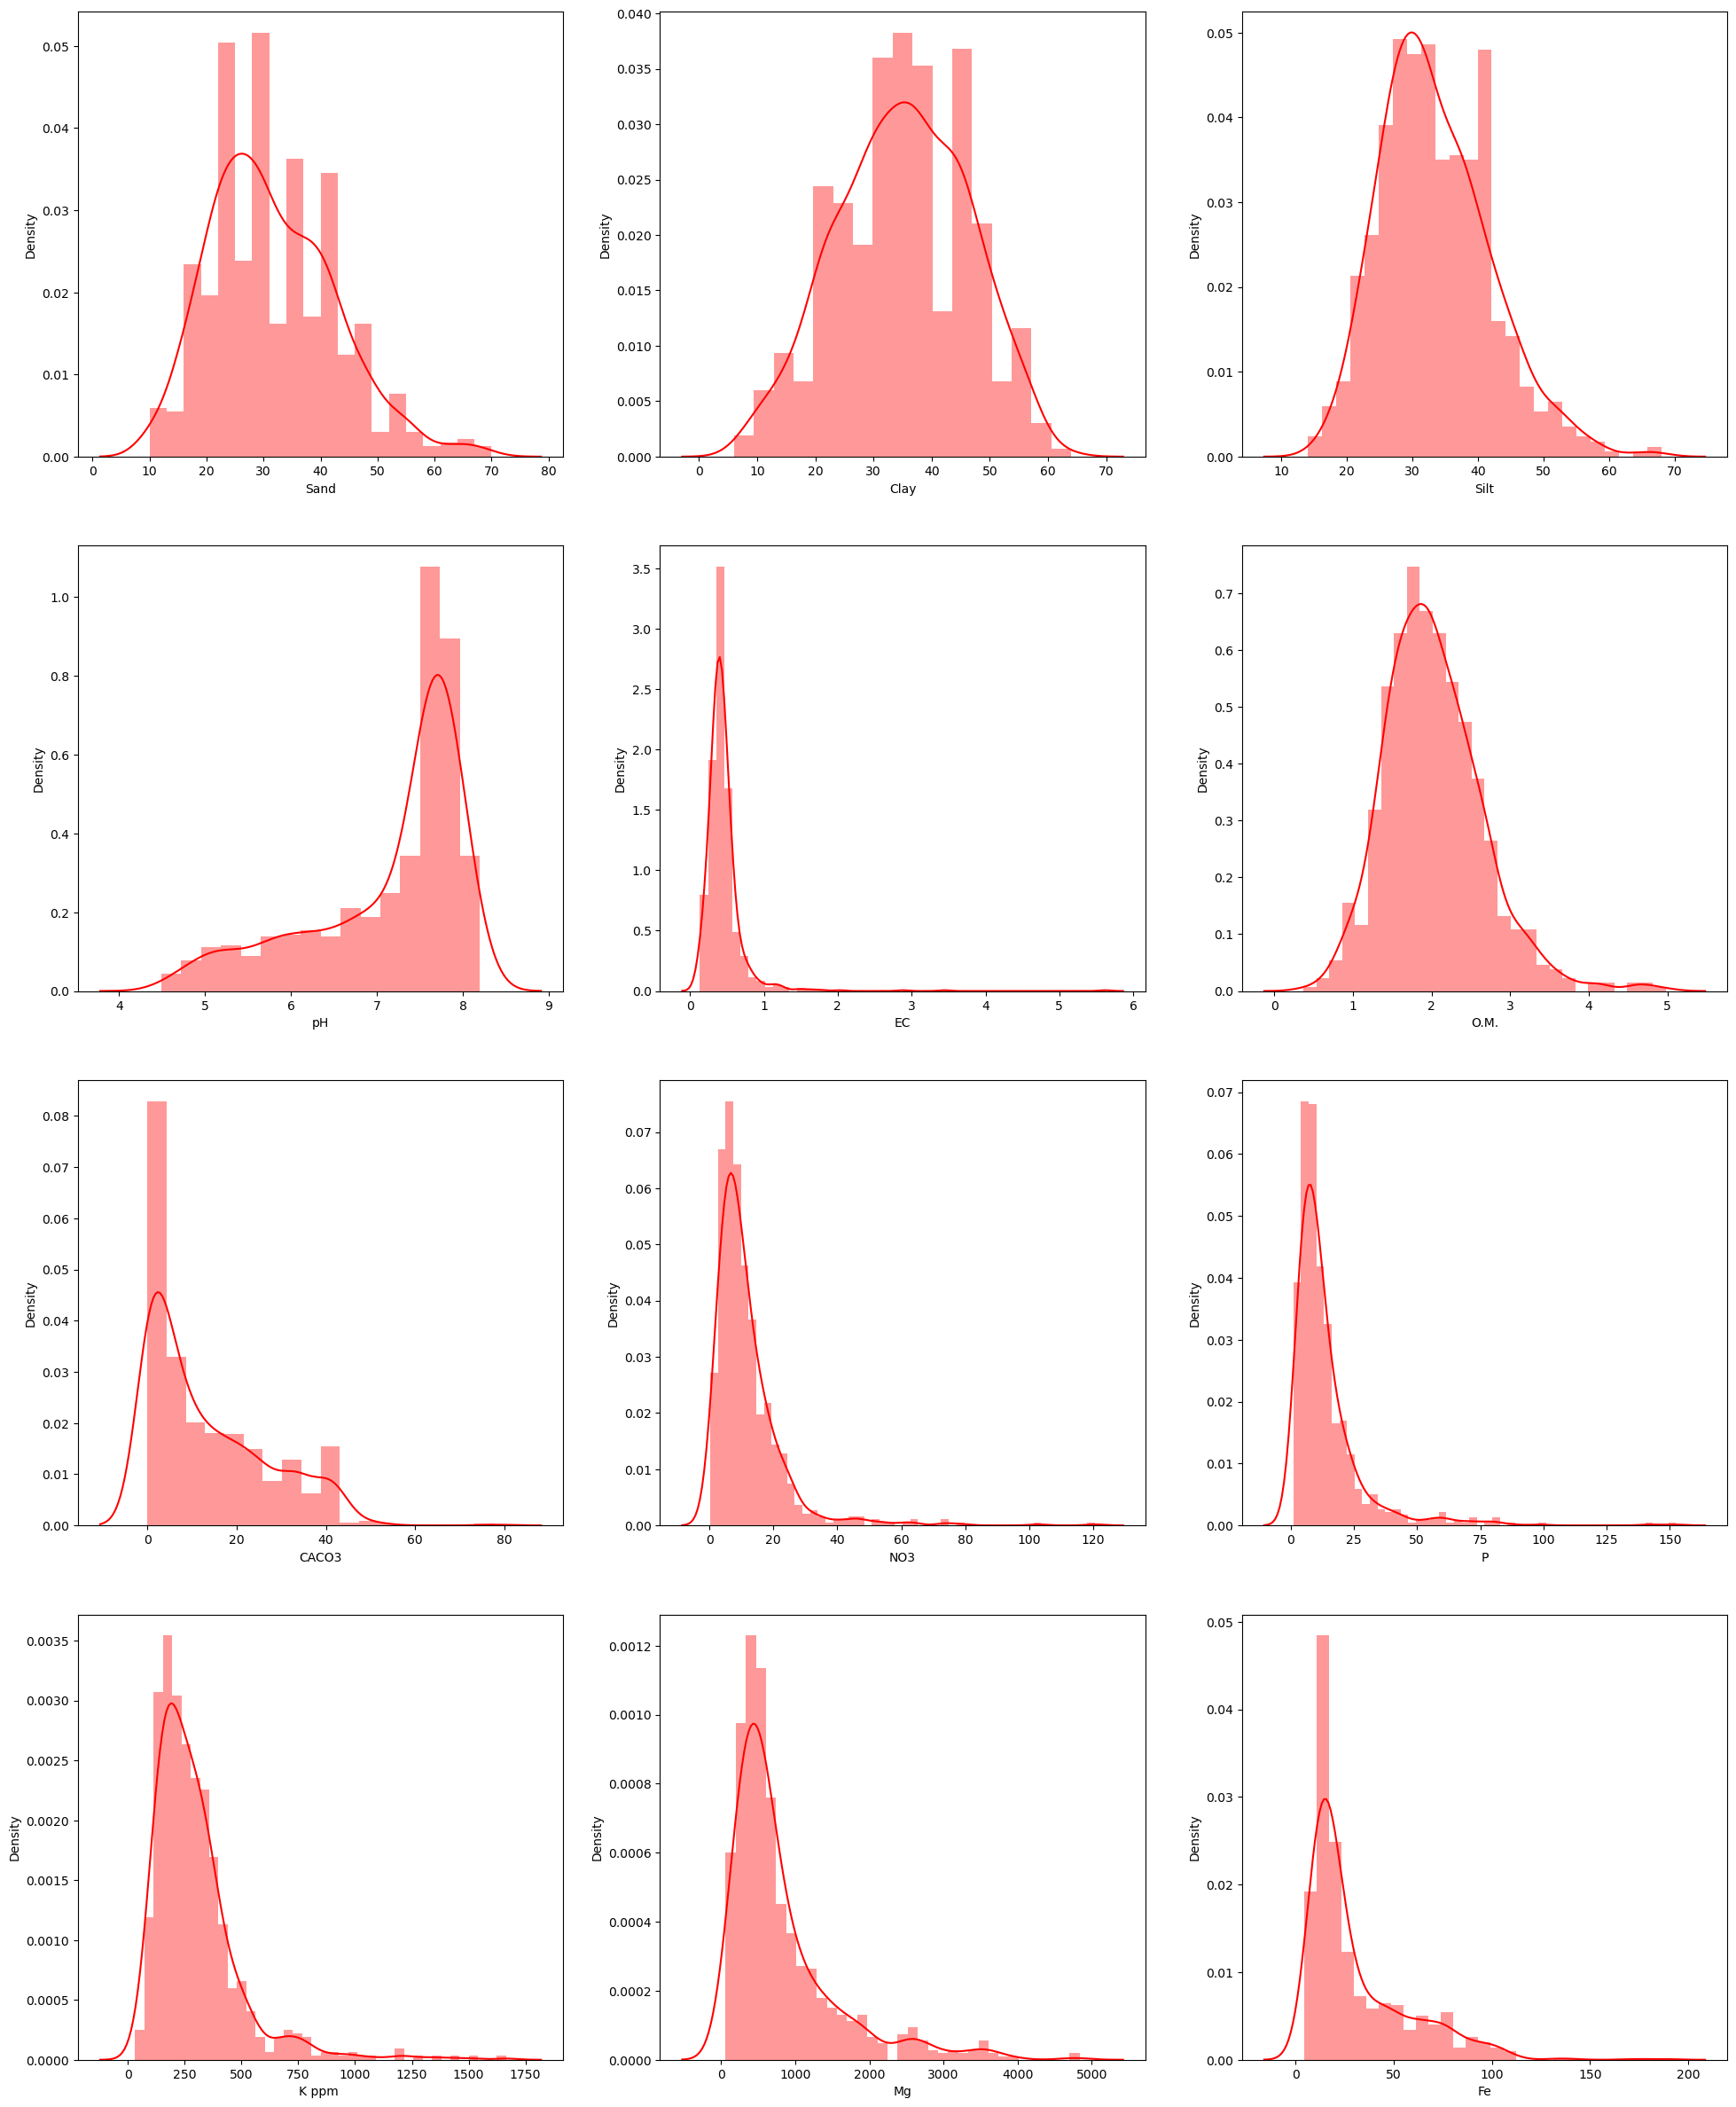

In [7]:
fig, ax = plt.subplots(4,3, figsize=(24,30))
k = 0
cols = list(df2.columns)
for i in range(4):
    for j in range(3):
            sns.distplot(df2[cols[k]], ax = ax[i][j], color = 'red')
            k += 1
plt.show()

Since the vast majority of our plots are heavily skewed to the right this is a big sign that outliers exist in our dataset. We will now do a number of box plots in order to check whether our hypothesis is true.

In [9]:
for col in df2.columns[:-1]:
    fig = px.box(df2, y=col)
    fig.update_layout(height=500, width=1000,
    title={
        'text': col.upper(),
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })
    fig.show()

In most of our data we can very clearly see that we have a lot of outliers. We will treat them once we are finished with our EDA.

Next we will print a correlation heatmap to see which characteristics have the biggest impact to our target variable.

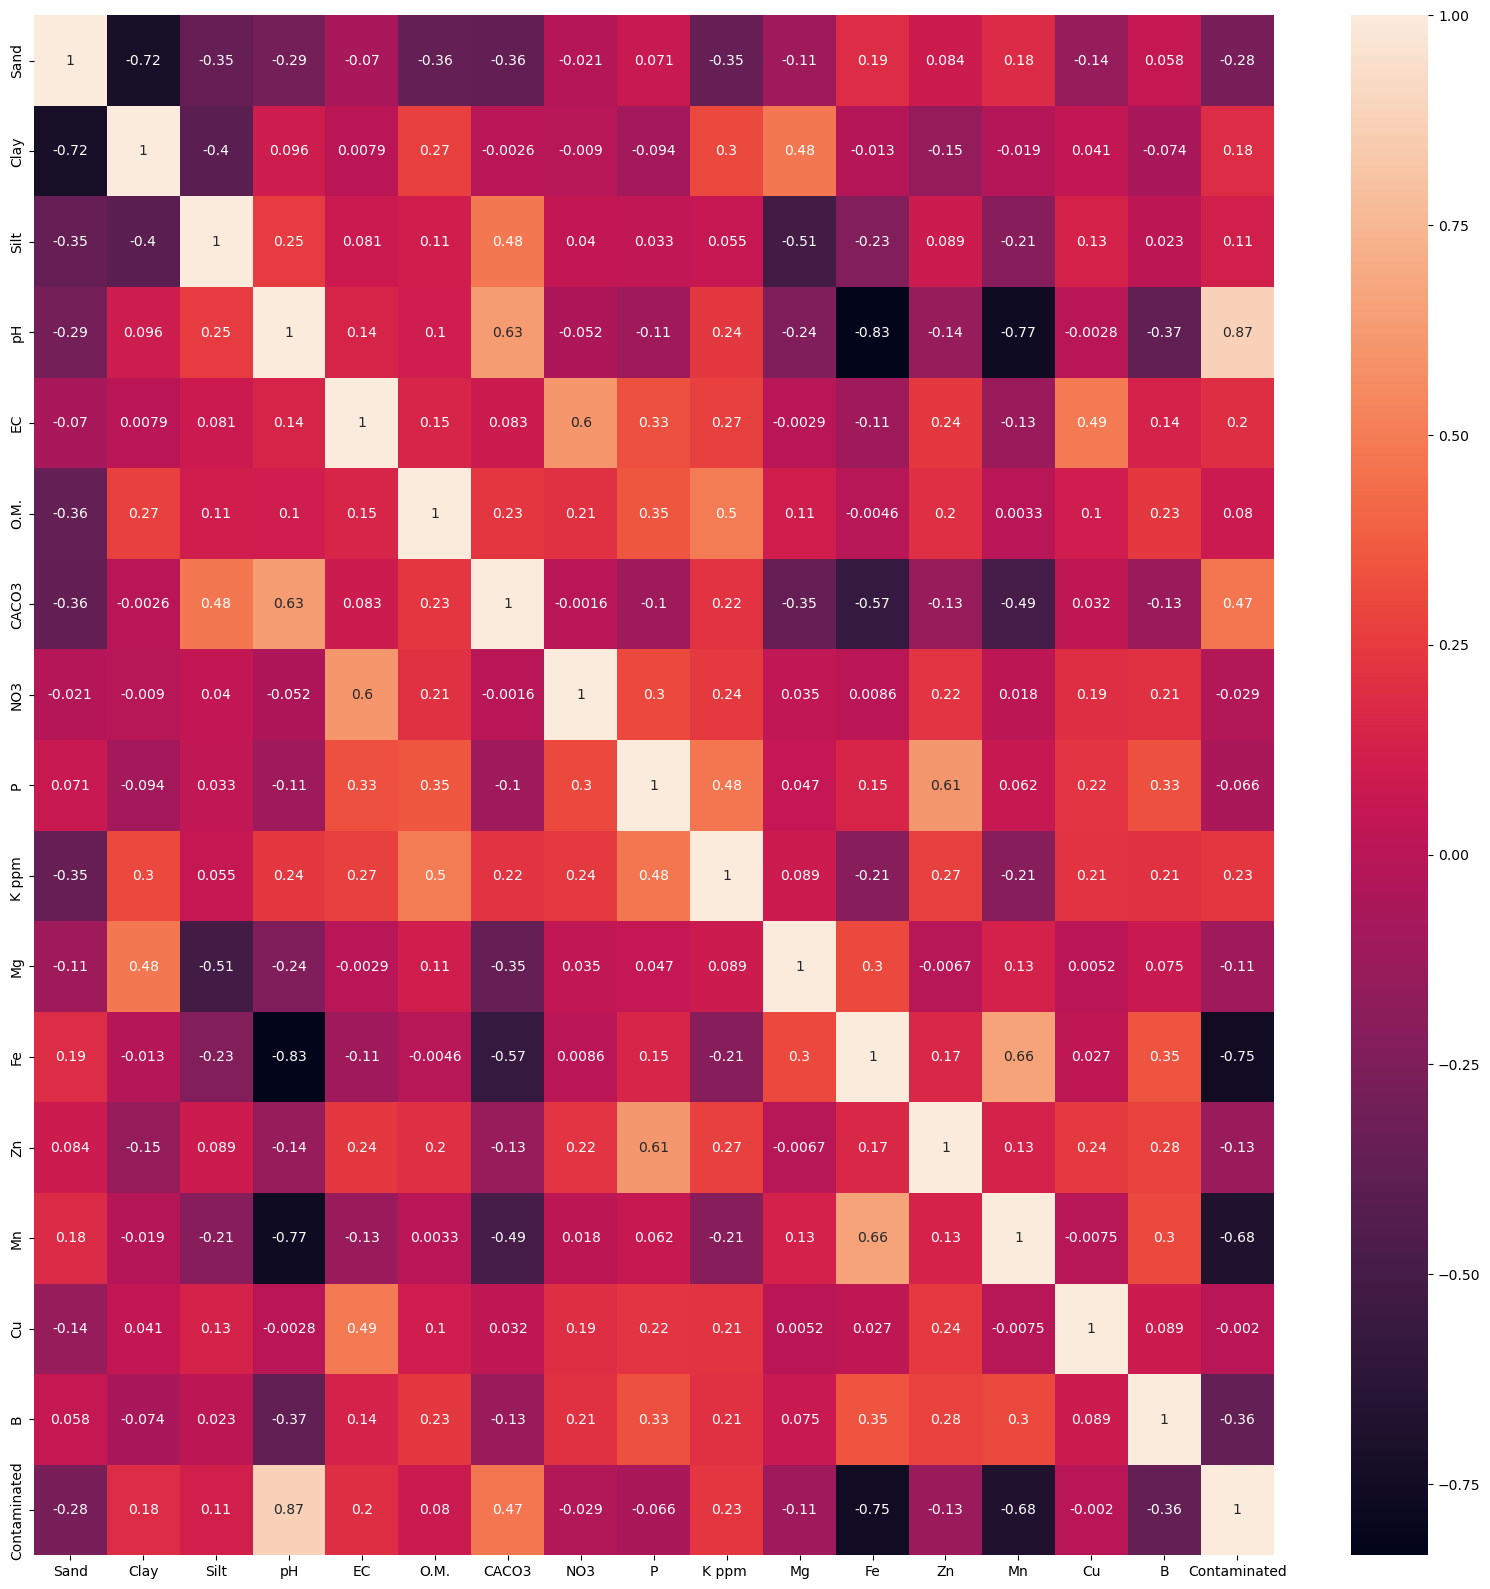

In [8]:
df2.corr()
plt.figure(figsize = (20,20))
sns.heatmap(df2.corr(), annot=True, cmap= 'rocket')
plt.show()

We can now see that pH has the biggest correlation to the Contaminated variable, with a 0.87 correlation score.

We now create a function to modify our outliers based on the general lower and upper values of our Data.

In [10]:
def mod_outlier(df2):
    df = df2.copy()
    df = df._get_numeric_data()
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)

    iqr = q3-q1

    lower_bound = q1 -(1.5*iqr)
    upper_bound = q3 +(1.5*iqr)

    for col in df.columns:
        for i in range(0,len(df[col])):
            if df[col][i] < lower_bound[col]:
                df[col][i] =  lower_bound[col]
            if df[col][i] > upper_bound[col]:
                df[col][i] = upper_bound[col]
    
    for col in df.columns:
        df[col] = df[col]
    
    return(df)

In [12]:
df.dtypes

ID                int64
Sand %          float64
Clay %          float64
Silt %          float64
pH              float64
EC mS/cm        float64
O.M. %          float64
CACO3 %         float64
N_NO3 ppm       float64
P ppm           float64
K ppm             int64
Mg ppm            int64
Fe ppm          float64
Zn ppm          float64
Mn ppm          float64
Cu ppm          float64
B ppm           float64
contaminated      int64
dtype: object

We will now Implement a train/test (80/20) split and Standard Scaling to our data in order to make it suitable for training our model.

In [13]:
X = df2.drop(columns=["Contaminated"])
y = df2["Contaminated"]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size= 0.2, random_state= 42,stratify=y)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

Finally we will create a function that will generate an ROC Curve and a Confusion matrix, along with a number of different metrics to asses the accuracy of different models, in order to pick the most suitable one.

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
from sklearn.metrics import ConfusionMatrixDisplay as cm
from sklearn.metrics import RocCurveDisplay as rc
def train_model(model):
    model.fit(X_train_scaled,y_train)
    y_pred=model.predict(X_test_scaled)
    y_prob=model.predict_proba(X_test_scaled)
    accuracy=np.round(round(accuracy_score(y_test,y_pred),3)*100,2)
    precision=np.round(round(precision_score(y_test,y_pred,average='weighted'),3)*100,2)
    recall=np.round(round(recall_score(y_test,y_pred,average='weighted'),3)*100,2)
    
    print(f'Accuracy of the model: {accuracy}%')
    print(f'Precision Score of the model: {precision}%')
    print(f'Recall Score of the model: {recall}%')
    print('-'*50)
    print(classification_report(y_test,y_pred))
    
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = cm.from_predictions(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = rc.from_predictions(y_test, y_pred, ax= ax[1])


## Logistic Regression

Accuracy of the model: 98.7%
Precision Score of the model: 98.7%
Recall Score of the model: 98.7%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        32
           1       0.99      0.99      0.99       125

    accuracy                           0.99       157
   macro avg       0.98      0.98      0.98       157
weighted avg       0.99      0.99      0.99       157



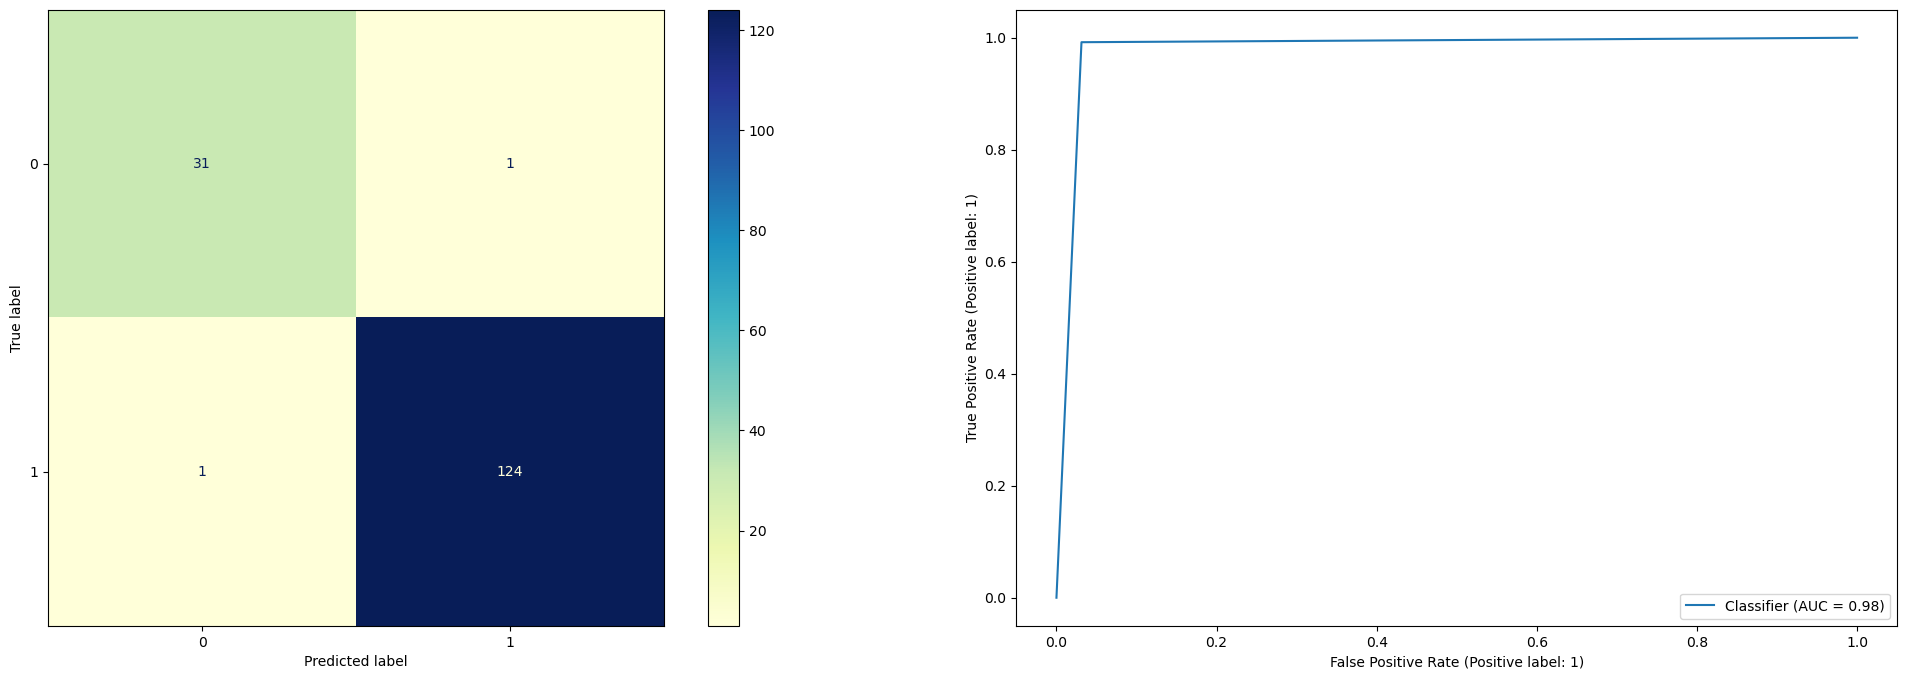

In [16]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
train_model(logreg)

## Gaussian Naive Bayes

Accuracy of the model: 95.5%
Precision Score of the model: 96.3%
Recall Score of the model: 95.5%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        32
           1       1.00      0.94      0.97       125

    accuracy                           0.96       157
   macro avg       0.91      0.97      0.94       157
weighted avg       0.96      0.96      0.96       157



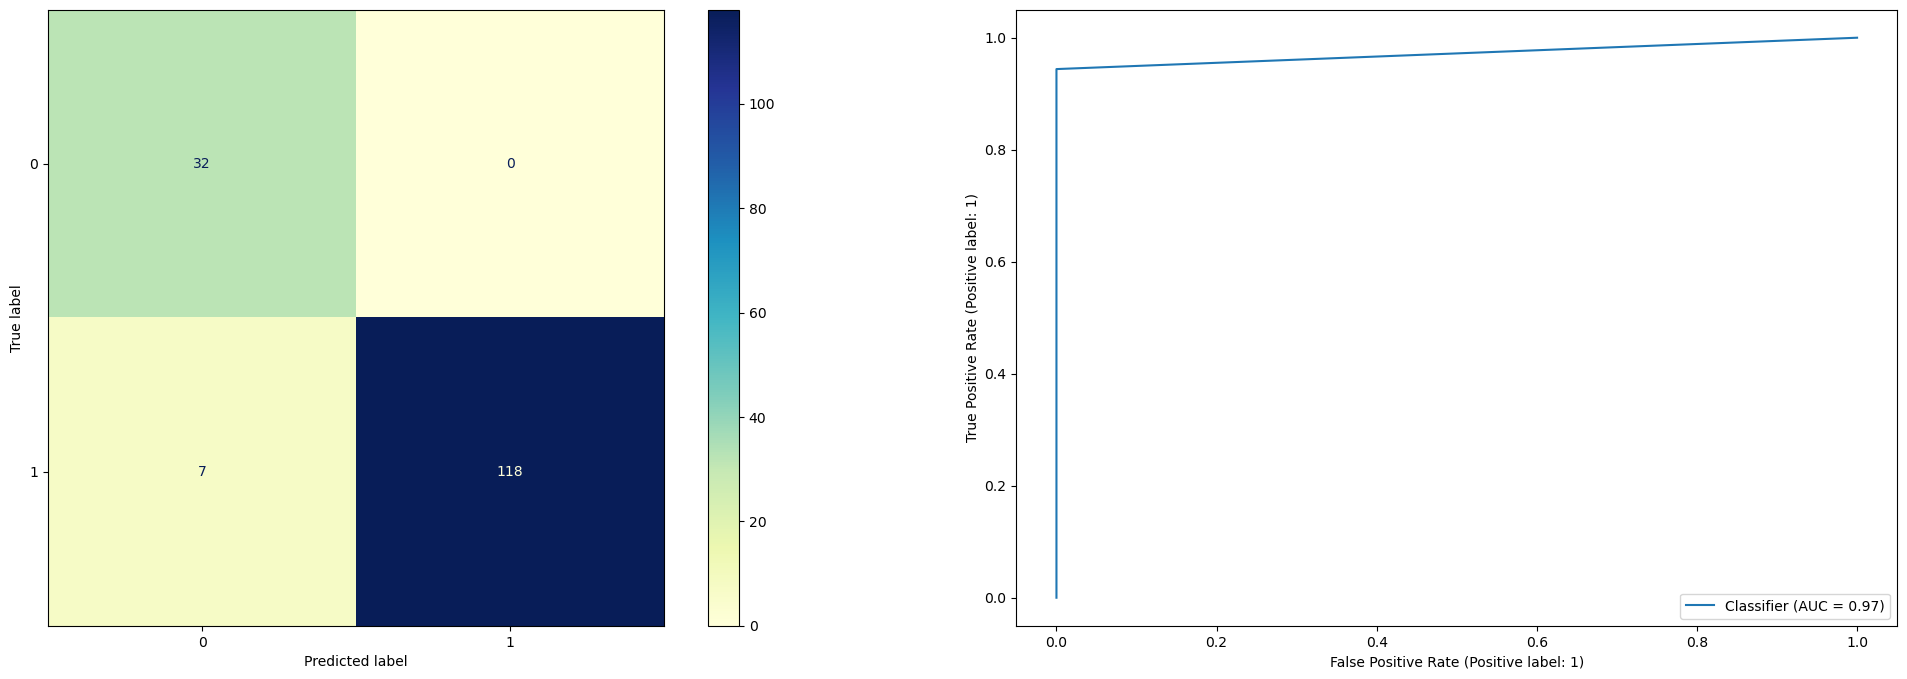

In [17]:

from sklearn.naive_bayes import GaussianNB

gnb=GaussianNB()
train_model(gnb)

## Bernoulli Naive Bayes

Accuracy of the model: 87.3%
Precision Score of the model: 90.9%
Recall Score of the model: 87.3%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.94      0.75        32
           1       0.98      0.86      0.91       125

    accuracy                           0.87       157
   macro avg       0.80      0.90      0.83       157
weighted avg       0.91      0.87      0.88       157



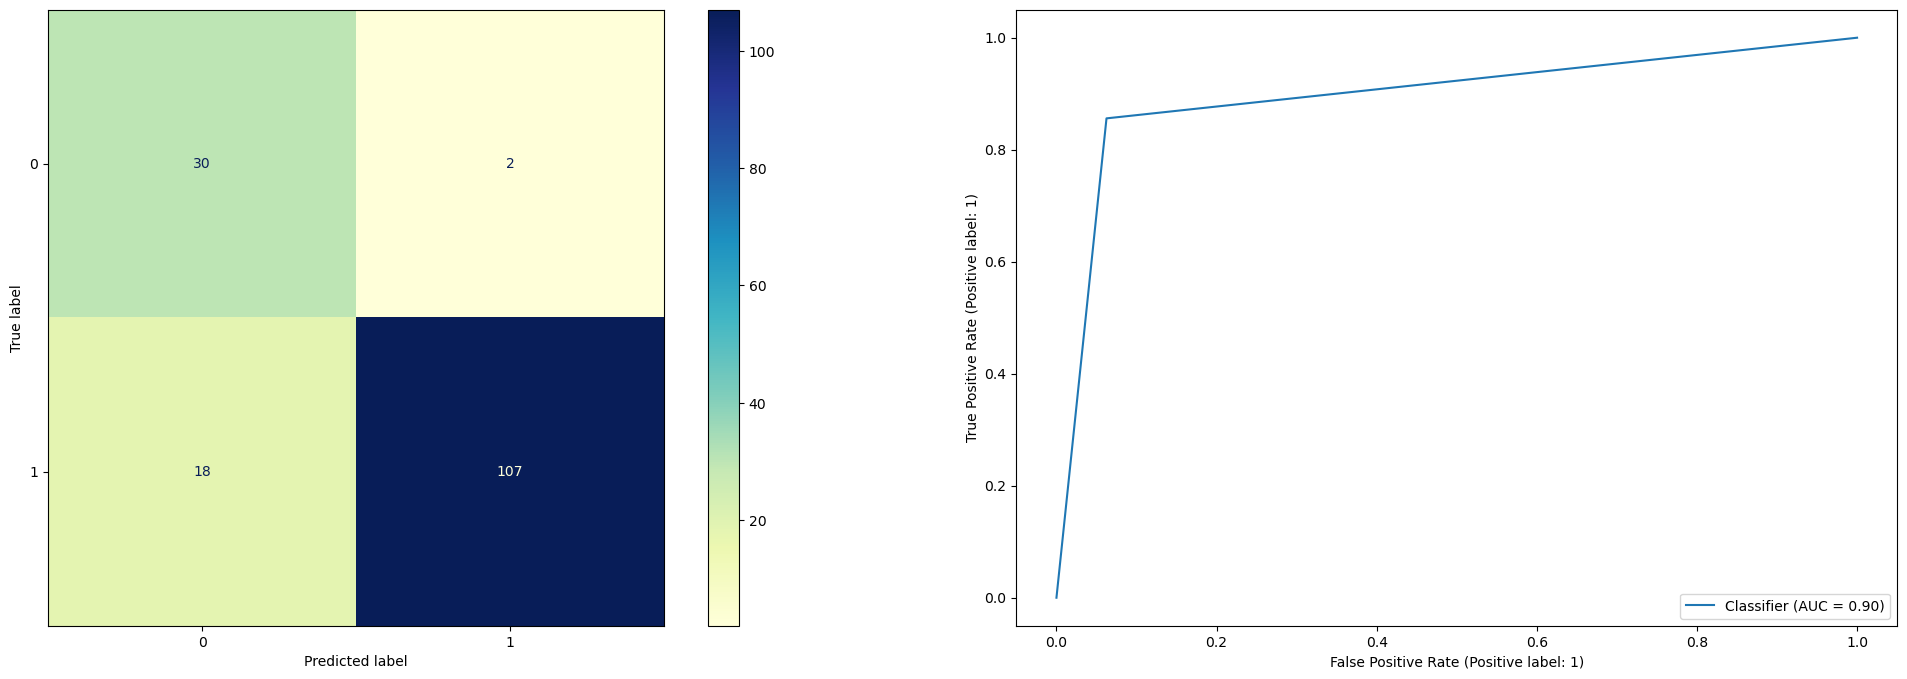

In [18]:

from sklearn.naive_bayes import BernoulliNB

bnb=BernoulliNB()
train_model(bnb)

## K-Nearest Neighbours

Accuracy of the model: 97.5%
Precision Score of the model: 97.5%
Recall Score of the model: 97.5%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        32
           1       0.98      0.98      0.98       125

    accuracy                           0.97       157
   macro avg       0.96      0.96      0.96       157
weighted avg       0.97      0.97      0.97       157



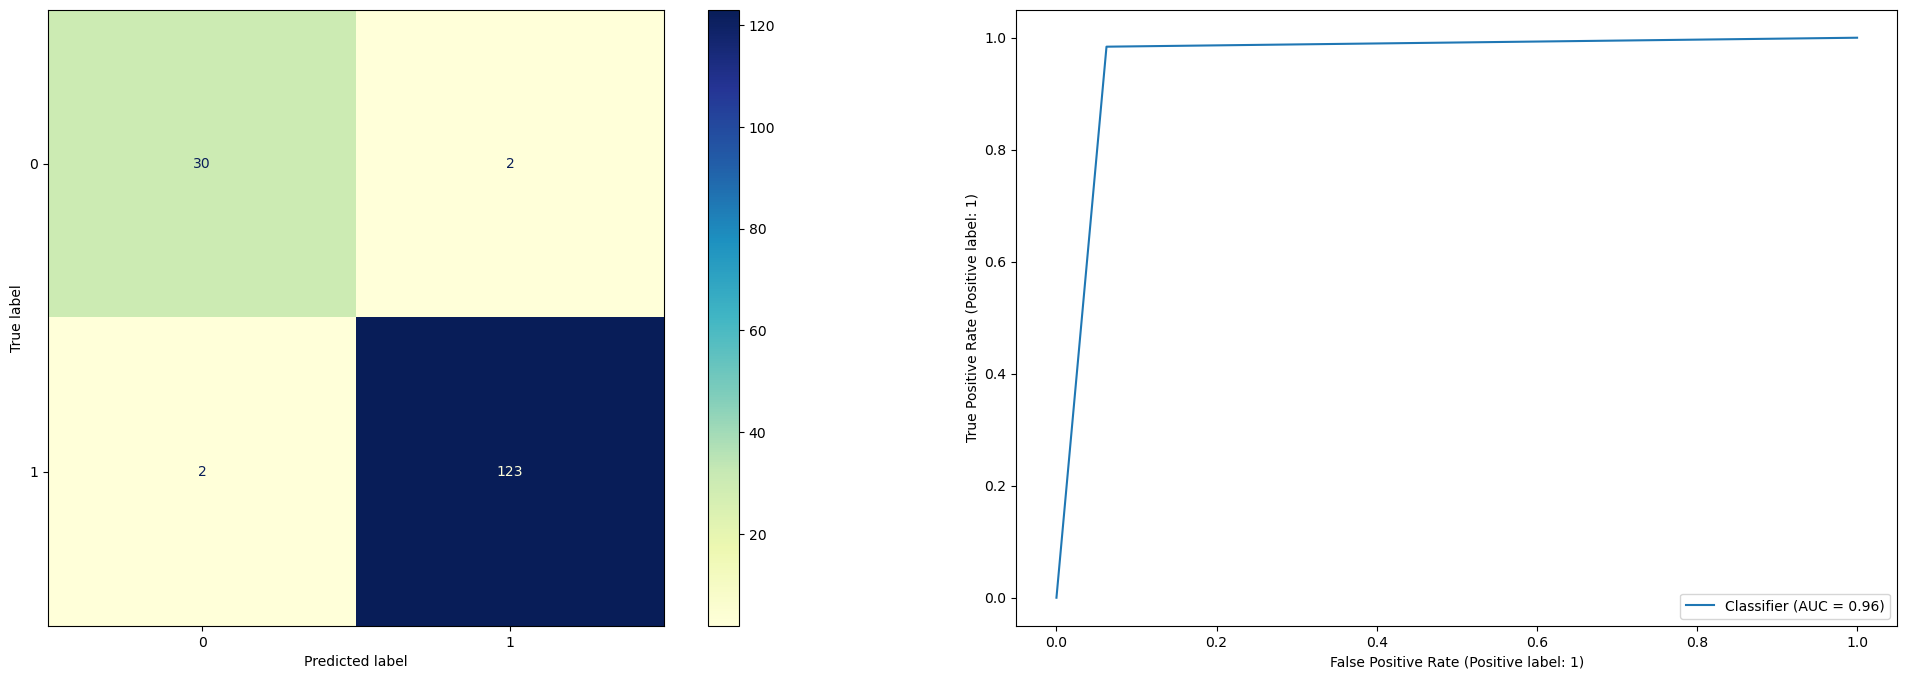

In [19]:

from sklearn.neighbors import KNeighborsClassifier

params = {"n_neighbors": np.arange(2, 50),
             "weights": ["uniform", "distance"]}

knn=KNeighborsClassifier()
knn_cv= GridSearchCV(knn,params, cv = 10)
train_model(knn_cv)

## Decision Tree

Accuracy of the model: 96.8%
Precision Score of the model: 96.9%
Recall Score of the model: 96.8%
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.84      0.92        32
           1       0.96      1.00      0.98       125

    accuracy                           0.97       157
   macro avg       0.98      0.92      0.95       157
weighted avg       0.97      0.97      0.97       157



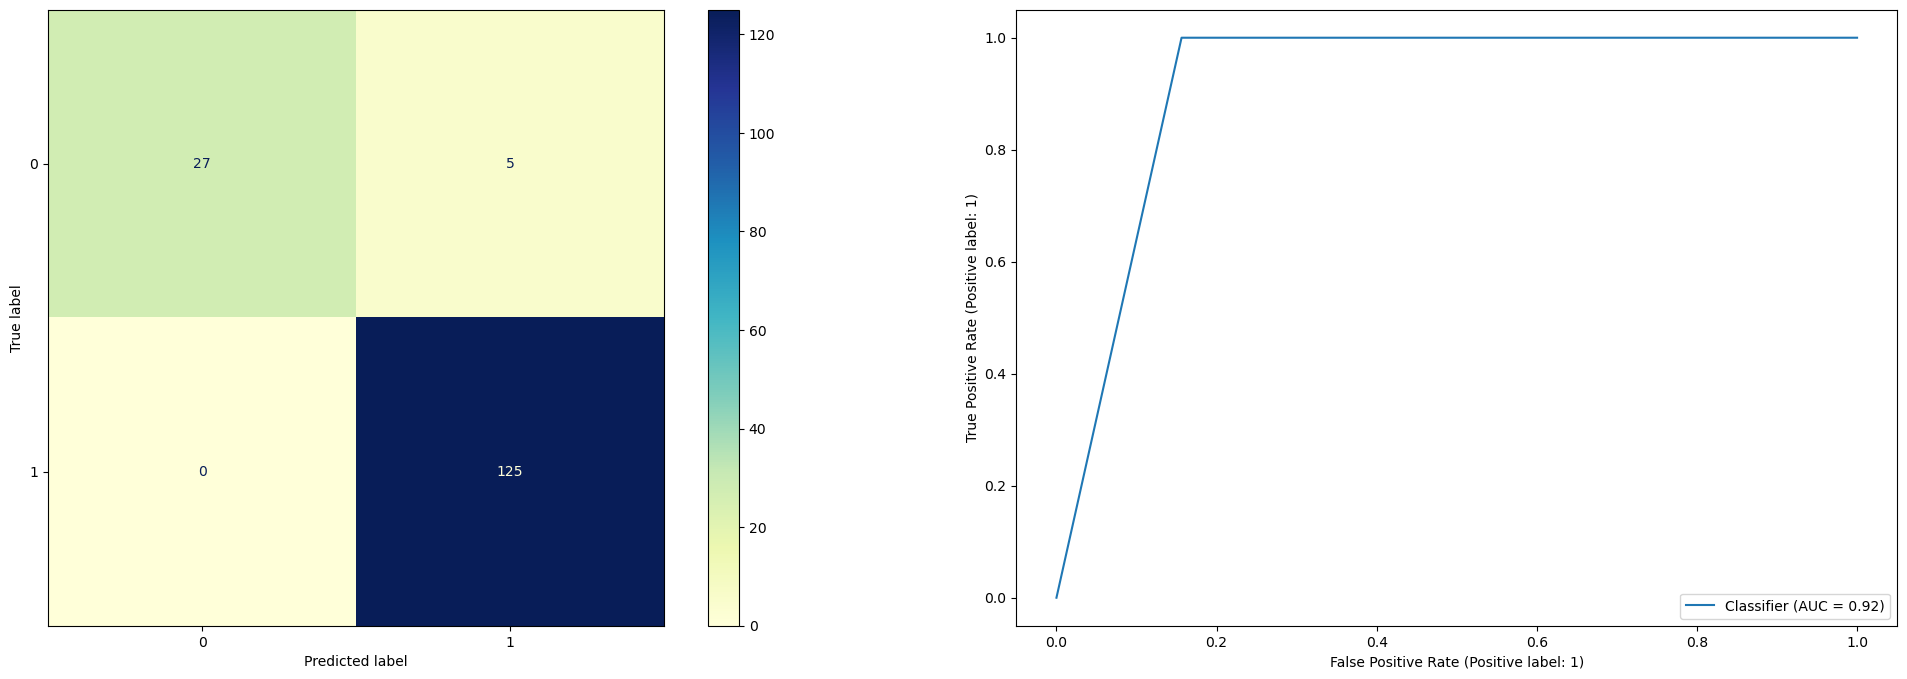

In [20]:

from sklearn.tree import DecisionTreeClassifier

param= {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }

dt= DecisionTreeClassifier(random_state=42)
dt_cv = GridSearchCV(dt, param_grid=param, cv=10)
train_model(dt_cv)

## Extra Trees

Accuracy of the model: 96.2%
Precision Score of the model: 96.3%
Recall Score of the model: 96.2%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        32
           1       0.98      0.97      0.98       125

    accuracy                           0.96       157
   macro avg       0.93      0.95      0.94       157
weighted avg       0.96      0.96      0.96       157



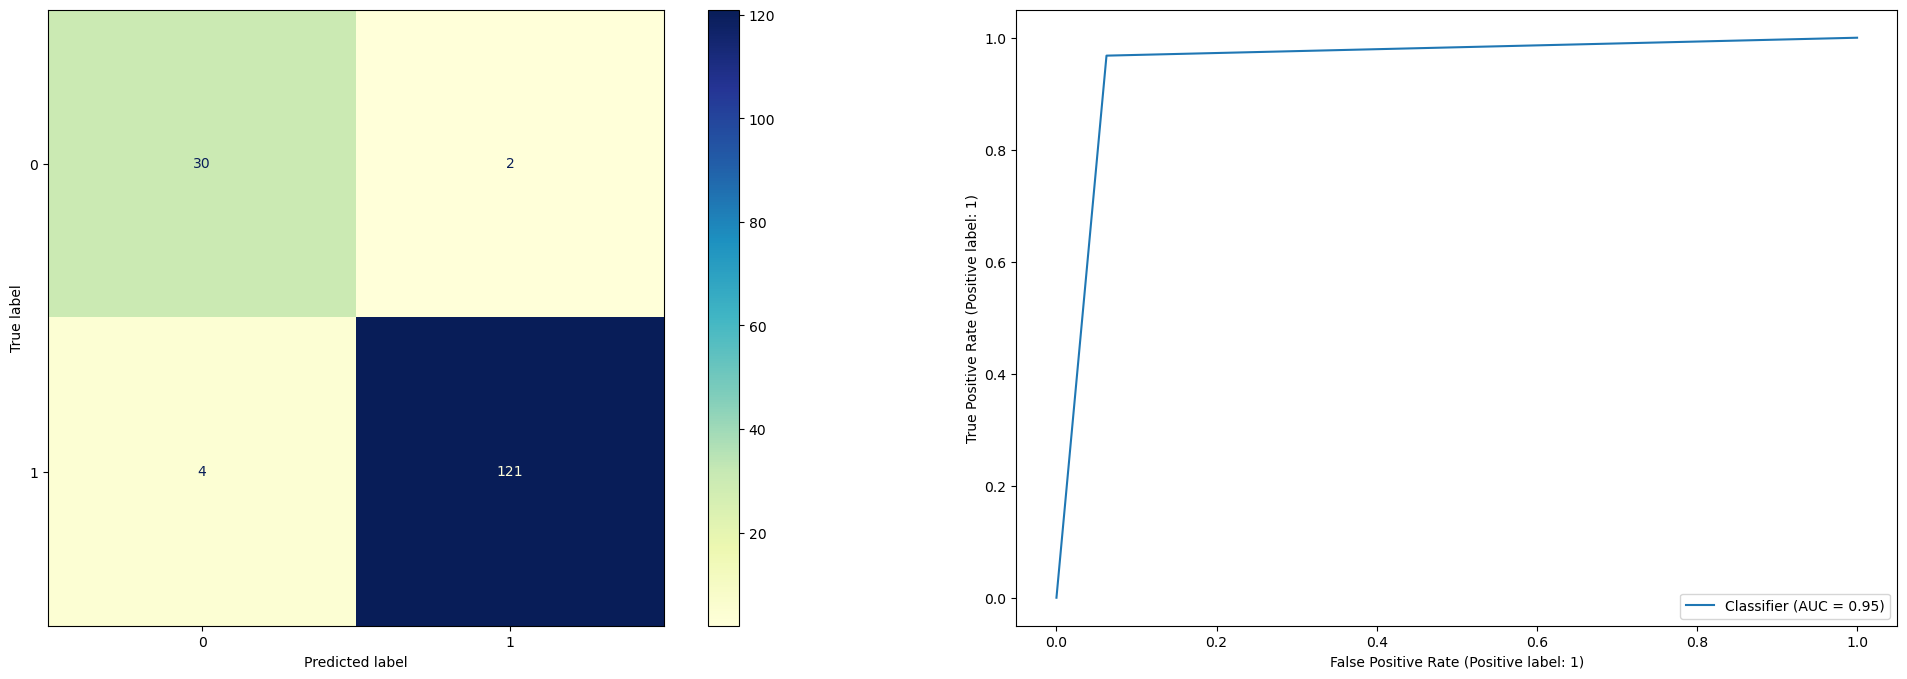

In [21]:

from sklearn.tree import ExtraTreeClassifier

et=ExtraTreeClassifier()
train_model(et)

## SVC-Radial

Accuracy of the model: 99.4%
Precision Score of the model: 99.4%
Recall Score of the model: 99.4%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.99      1.00       125

    accuracy                           0.99       157
   macro avg       0.98      1.00      0.99       157
weighted avg       0.99      0.99      0.99       157



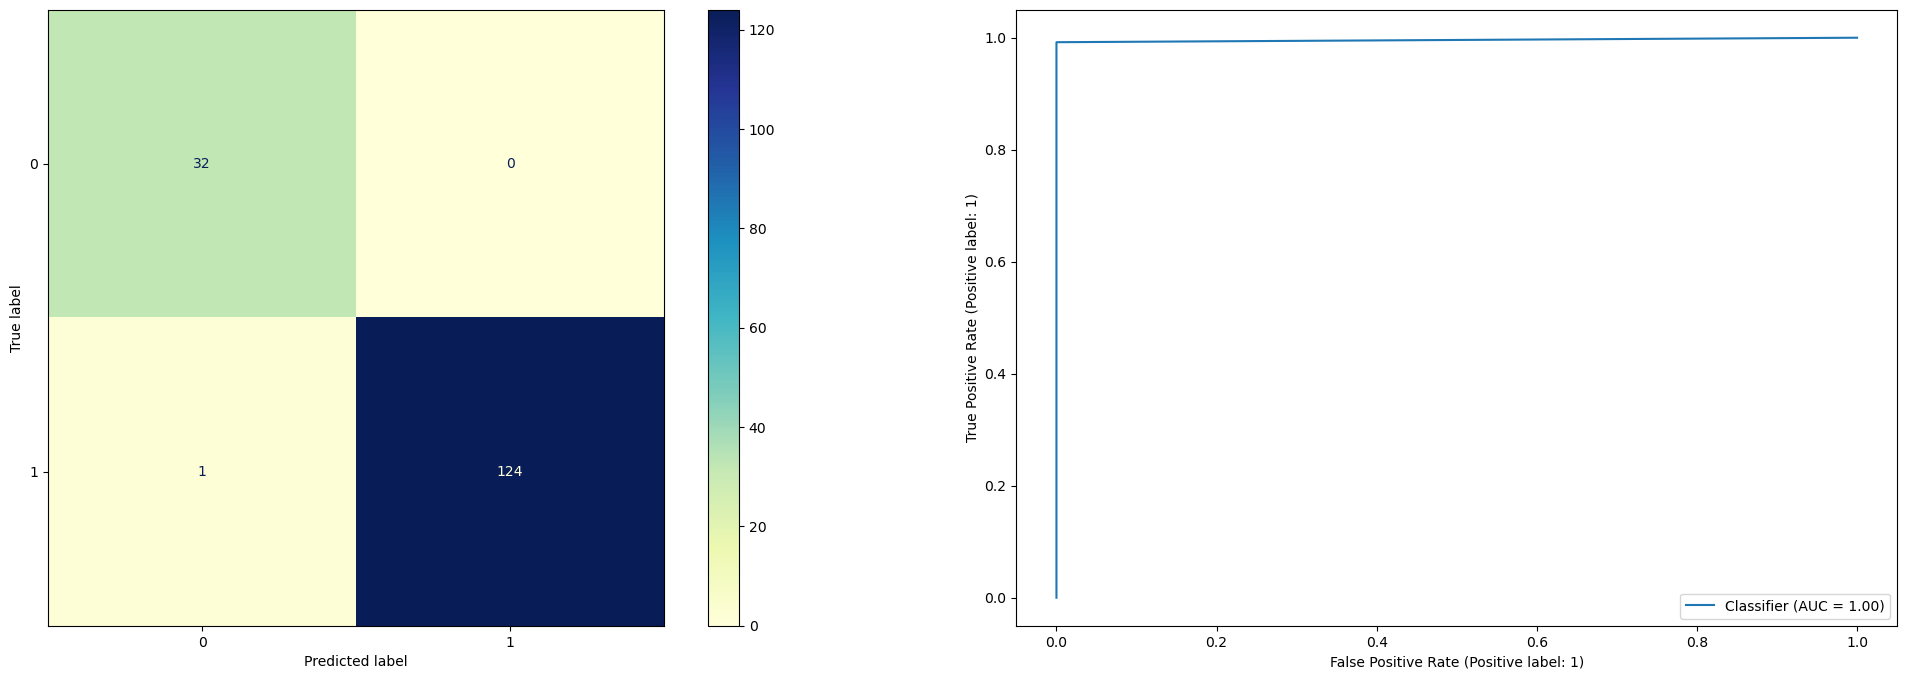

In [22]:

from sklearn.svm import SVC

param= {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
svm=SVC(probability=True)  
svm_cv = GridSearchCV(svm, param, cv=10)
train_model(svm_cv)

## Gradient Boosting

Accuracy of the model: 99.4%
Precision Score of the model: 99.4%
Recall Score of the model: 99.4%
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.99      1.00      1.00       125

    accuracy                           0.99       157
   macro avg       1.00      0.98      0.99       157
weighted avg       0.99      0.99      0.99       157



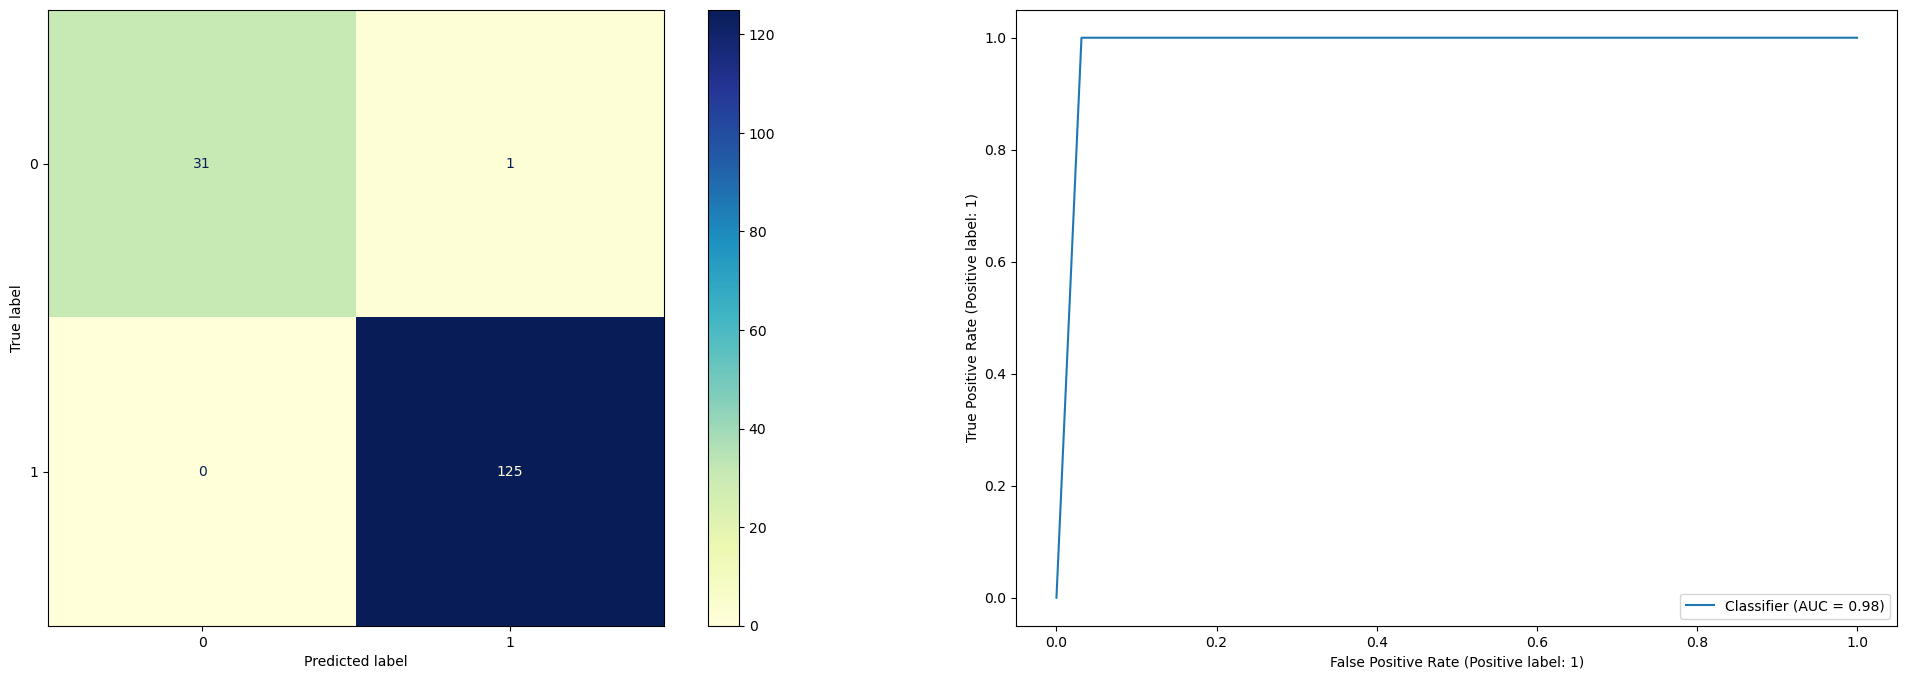

In [23]:

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier() 
train_model(gb)

## Bagging Classifier

Accuracy of the model: 99.4%
Precision Score of the model: 99.4%
Recall Score of the model: 99.4%
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.99      1.00      1.00       125

    accuracy                           0.99       157
   macro avg       1.00      0.98      0.99       157
weighted avg       0.99      0.99      0.99       157



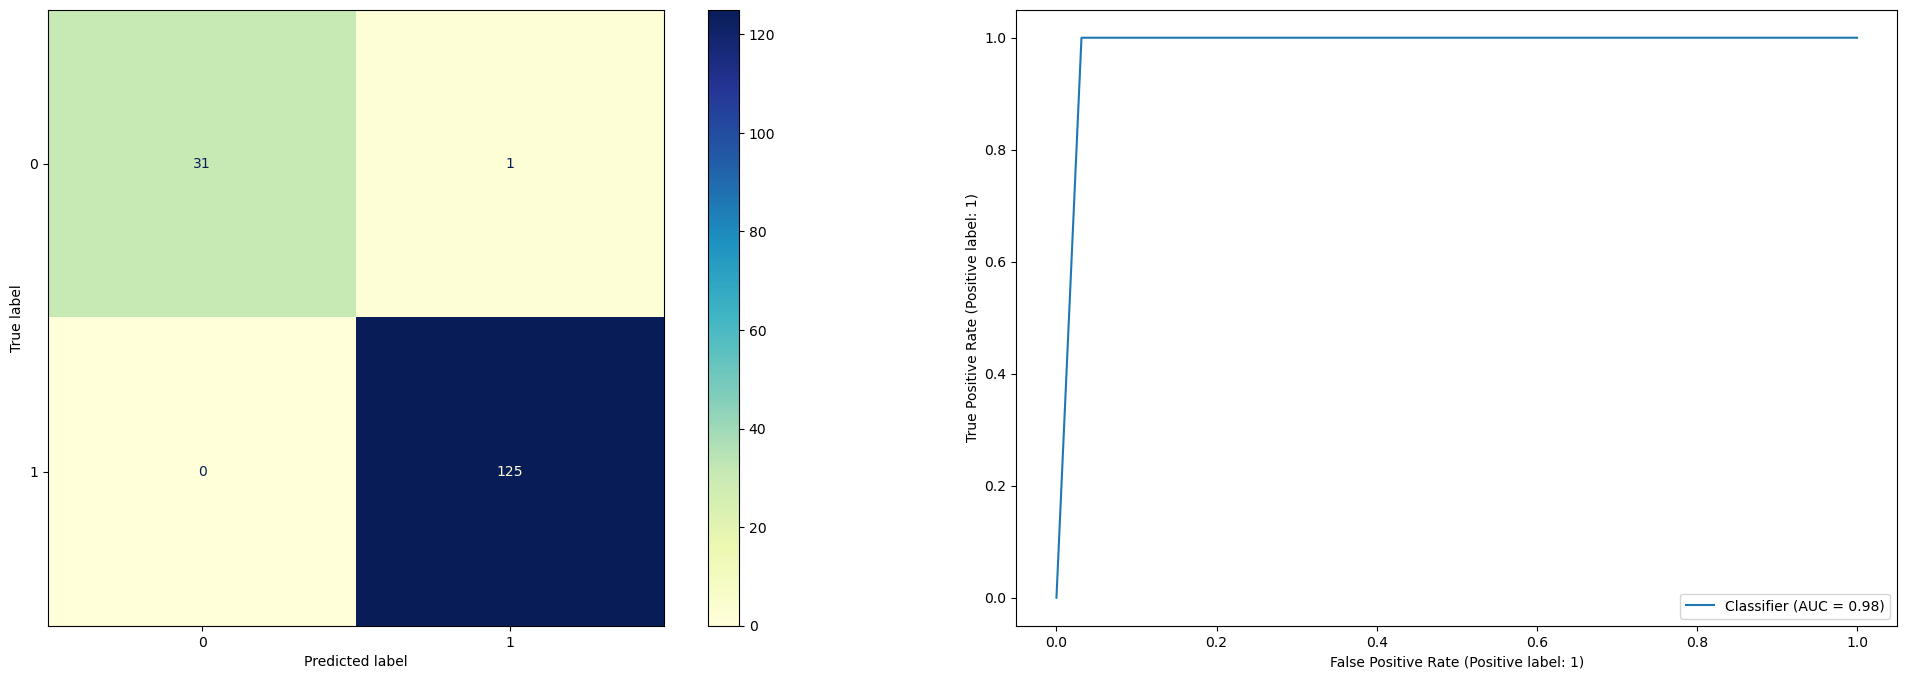

In [24]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200) 
train_model(bag)

We can clearly see that the Gradient boosting and Bagging classifier algorithms produce the best result with an astounding 99,4% accuracy score.